# ‘Optimal’ Decision-Making

##### 2024 Mar 1   Yide (Alex) Xu


In this blog post, I extened on what we have learned during the lecture on making (binary) decisions based on a linear score function. During the class, we simplified the process by using only two features and failing to make an attempt to find an optimal vector of weights. In this blog post, I will explore a way to find the optimal weight vector $\mathbf{w}$ using the logistic regression method and incorporated formulas that calculate the bank's gain/loss on each loan to find the threshold that would help the bank to make the most profitable decision on loan granting. After testing the model that I build on a testing data set, I found that my model would less likely to grant loans to people within the 20 to 30 year age range and more favorable to people with higher income and lower interest rate. 

### Part A: Grab the Data

First, we want to download the training data.

In [254]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")


url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv"
df_train = pd.read_csv(url)
df_train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,25,43200,RENT,NaN,VENTURE,B,1200,9.91,0,0.03,N,4
1,27,98000,RENT,3.0,EDUCATION,C,11750,13.47,0,0.12,Y,6
2,22,36996,RENT,5.0,EDUCATION,A,10000,7.51,0,0.27,N,4
3,24,26000,RENT,2.0,MEDICAL,C,1325,12.87,1,0.05,N,4
4,29,53004,MORTGAGE,2.0,HOMEIMPROVEMENT,A,15000,9.63,0,0.28,N,10


The columns in this data are:

- `person_age`, the age of the prospective borrower.
- `person_income`, the income of the prospective borrower at time of application.
- `person_home_ownership`, the home ownership status of the prospective borrower at time of application. Possible values are MORTGAGE, OWN, RENT, and OTHER.
- `person_emp_length`, the length of most recent employment for the prospective borrower, in years.
- `loan_intent`, the purpose of the loan request.
- `loan_grade`, a composite measure of the likelihood of the borrower to repay the loan. 
- `loan_amnt`, the amount of the loan.
- `loan_int_rate`, the annual interest rate on the loan.
- `loan_status`, whether or not the borrower defaulted on the loan. *This is the target variable.*
- `loan_percent_income`, the amount of the loan as a percentage of the prospective borrower’s personal income.
- `cb_person_default_on_file`, whether the prospective borrower has previously defaulted on a loan in the records of a credit bureau.
- `cb_person_cred_hist_length`, the length of credit history of the prospective borrower.

### Part B: Explore the Data

From this data, I first want to know how does different loan intent vary with age? People within different age range may have different needs for money. I would like to see how the data set says about how different age group would have different purpose in borrowing money from the bank. 

Fist, I would classify each individual in the data set into different age range. 

In [256]:
age_ranges = [(10, 20), (20, 30), (30, 40), (40, 50), (50, 60), (60, 70), (70, 80)]

def assign_age_range(age):
    for lower, upper in age_ranges:
        if lower <= age < upper:
            return f"{lower}-{upper}"

df_train['Age_Range'] = df_train['person_age'].apply(assign_age_range)
df_train.head()


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,Age_Range
0,25,43200,RENT,NaN,VENTURE,B,1200,9.91,0,0.03,N,4,20-30
1,27,98000,RENT,3.0,EDUCATION,C,11750,13.47,0,0.12,Y,6,20-30
2,22,36996,RENT,5.0,EDUCATION,A,10000,7.51,0,0.27,N,4,20-30
3,24,26000,RENT,2.0,MEDICAL,C,1325,12.87,1,0.05,N,4,20-30
4,29,53004,MORTGAGE,2.0,HOMEIMPROVEMENT,A,15000,9.63,0,0.28,N,10,20-30


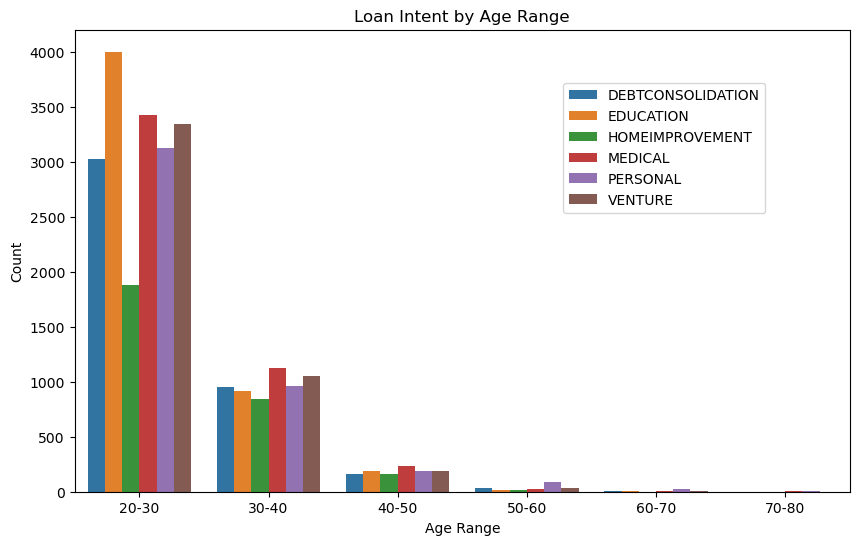

In [257]:
age_intent = df_train.groupby(["Age_Range", 'loan_intent']).size().reset_index(name='count')


plt.figure(figsize=(10, 6))
sns.barplot(data=age_intent, x='Age_Range', y='count', hue='loan_intent')
plt.title('Loan Intent by Age Range')
plt.xlabel('Age Range')
plt.ylabel('Count')
plt.legend(bbox_to_anchor=(0.9, 0.9), loc='upper right')
plt.show()

The number of individuals within 20 to 30 years old who are seeking loans is significantly higher than all other age groups. There are smaller proportion of this age group population that are seeking home improvement loans comparing to other loan intentions. As the age increases, there are less incident of people looking for loan from the bank. 

Next, I want to see how interest rates are set given people with different income level. Also, how does an individual's credit history affect the interest rate. 

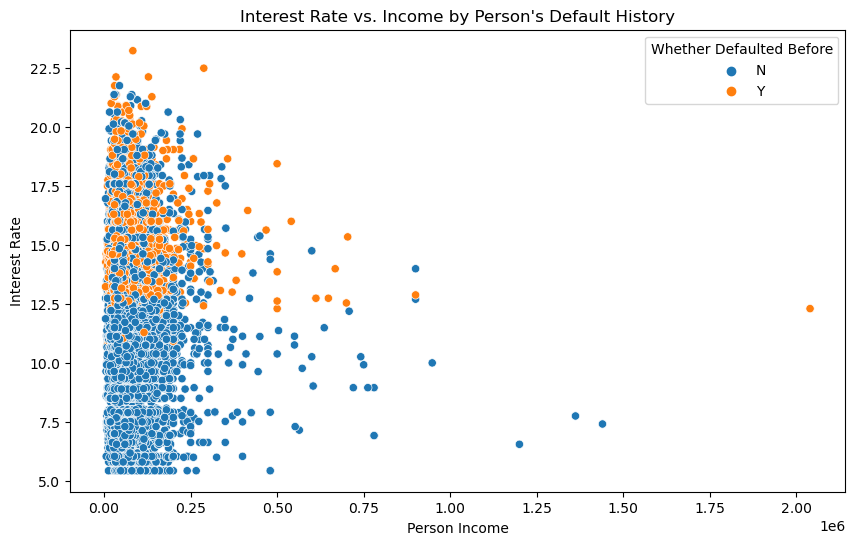

In [258]:
df_train['person_emp_length'].fillna(0, inplace=True)
df_train = df_train[df_train['person_emp_length'] <= 50]
df_train = df_train[df_train['person_income'] <= 3000000]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_train, x='person_income', y='loan_int_rate', hue= 'cb_person_default_on_file')
plt.title("Interest Rate vs. Income by Person's Default History")
plt.xlabel('Person Income')
plt.ylabel('Interest Rate')
plt.legend(title='Whether Defaulted Before')
plt.show()

It is apparent that people who have defaulted before receive higher interest rates. In fact, almost all of the individuals who have defaulted before will have an interest rate that is higher than 12.5 percent. In terms of interest rates' relation with income, people with higher income usually receive lower interest rate. Last but not least, I want to see how interest rate is affected by other variables, namely age, home ownership, and loan intention. 

Text(0, 0.5, 'Default History')

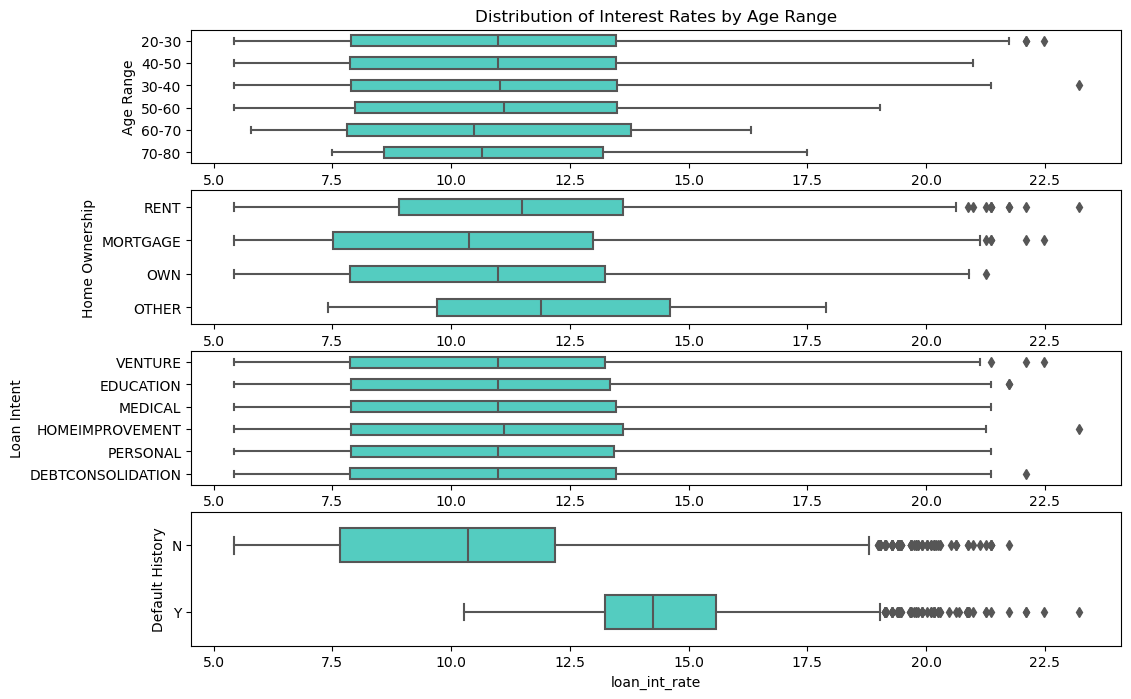

In [259]:
plt.figure(figsize=(12, 8))

plt.subplot(411)
sns.boxplot(data=df_train, x='loan_int_rate', y='Age_Range', color='turquoise', width=0.5)
plt.title('Distribution of Interest Rates by Age Range')
plt.ylabel('Age Range')

plt.subplot(412)
sns.boxplot(data=df_train, y='person_home_ownership', x='loan_int_rate', color='turquoise', width=0.5)
plt.ylabel('Home Ownership')


plt.subplot(413)
sns.boxplot(data=df_train, y='loan_intent', x='loan_int_rate', color='turquoise', width=0.5)
plt.ylabel('Loan Intent')

plt.subplot(414)
sns.boxplot(data=df_train, y='cb_person_default_on_file', x='loan_int_rate', color='turquoise', width=0.5)
plt.ylabel('Default History')


Compared to the interest rate's difference in the defult history variable, the differences of interest rates within other variables (age, home ownership, and loan intent) are not that significant. 

### Build a Model

Before we dive into building a model, we want to prepare the data for training. We first seperate our target variable from the training data and create dummy variables. 

In [260]:
from itertools import combinations
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score


def prepare_data(df_train):
  df_train = df_train.dropna()
  y = df_train["loan_status"]
  df = df_train.drop(["loan_status"], axis = 1)
  df = pd.get_dummies(df)
  return df, y

X_train, y_train = prepare_data(df_train)
X_train.head(10)


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y,Age_Range_20-30,Age_Range_30-40,Age_Range_40-50,Age_Range_50-60,Age_Range_60-70,Age_Range_70-80
0,25,43200,0.0,1200,9.91,0.03,4,False,False,False,...,False,False,True,False,True,False,False,False,False,False
1,27,98000,3.0,11750,13.47,0.12,6,False,False,False,...,False,False,False,True,True,False,False,False,False,False
2,22,36996,5.0,10000,7.51,0.27,4,False,False,False,...,False,False,True,False,True,False,False,False,False,False
3,24,26000,2.0,1325,12.87,0.05,4,False,False,False,...,False,False,True,False,True,False,False,False,False,False
4,29,53004,2.0,15000,9.63,0.28,10,True,False,False,...,False,False,True,False,True,False,False,False,False,False
6,21,21700,2.0,5500,14.91,0.25,2,False,False,False,...,False,False,True,False,True,False,False,False,False,False
7,39,43000,3.0,6250,7.68,0.15,14,True,False,False,...,False,False,True,False,False,True,False,False,False,False
8,36,59004,11.0,10000,7.51,0.17,15,True,False,False,...,False,False,True,False,False,True,False,False,False,False
9,22,34500,2.0,5000,16.89,0.14,3,False,False,False,...,False,False,True,False,True,False,False,False,False,False
10,22,33640,4.0,12000,10.65,0.36,3,True,False,False,...,False,False,True,False,True,False,False,False,False,False


I would like to fit a Logistic Regression model as the score-based machine learning model to the data. First, I want to select my features. According to my exploration, I found that people who have defaulted their previous loan(s) are more likely to have higher interest rate, which could lead to higher risk of defaulting on a new loan. Therefore, I  include both the default history and the loan interest rate as the features to predict loan defaulting. Next, I include `loan_percent_income` because it reflects the ability for an individual to pay the interest using its source of income. Lastly, I include the individual's home ownerhsip status as a factor because unstable shelter status could deprecate one's ability to pay back the loan. 

In [261]:
LR = LogisticRegression()

quant = ["loan_percent_income", "loan_int_rate"]
selected_columns = ["loan_percent_income", "loan_int_rate", "person_home_ownership_MORTGAGE", "person_home_ownership_OTHER", "person_home_ownership_OWN", "person_home_ownership_RENT", "cb_person_default_on_file_N", "cb_person_default_on_file_Y"]

LR.fit(X_train[selected_columns], y_train)
cv_scores_LR = cross_val_score(LR, X_train[selected_columns], y_train, cv = 5).mean()

cv_scores_LR

0.8436196450239821

Here we have the weight vector $\mathbf{w}$ 

In [262]:
LR.coef_[0]

array([ 8.55153096,  0.27487555, -0.04240708,  0.29801174, -1.11860094,
        0.9429623 , -0.01229506,  0.09226108])

### Part D: Find a Threshold

In [263]:
def score_function(coef, cols, df):
    scores = np.dot(df[cols].values, coef[0])
    return scores

X_train['new_score'] = score_function(LR.coef_, selected_columns, X_train)

In [264]:
best_profit = 0
best_t = 0
X_train["real_default"] = y_train
T = np.linspace(X_train['new_score'].min()-0.1, X_train['new_score'].max()+0.1, 120)
profit_frame = pd.DataFrame(columns=['threshold', 'profit'])


for t in np.linspace(X_train['new_score'].min()-0.1, X_train['new_score'].max()+0.1, 120):
    #y_pred = X_train['new_score'] >= t

    TrueNegative = X_train[(X_train['new_score'] < t) & (X_train['real_default'] == 0)]
    TrueNegative_list = TrueNegative["loan_amnt"] * (1 + 0.25 * TrueNegative["loan_int_rate"]/100)**10 - TrueNegative["loan_amnt"]
    TrueNegative_gain = TrueNegative_list.sum()

    FalseNegative = X_train[(X_train['new_score'] < t) & (X_train['real_default'] == 1)]
    FalseNegative_list = FalseNegative["loan_amnt"] * (1 + 0.25 * FalseNegative["loan_int_rate"]/100)**3 - 1.7 * FalseNegative["loan_amnt"]
    FalseNegative_cost = FalseNegative_list.sum()

    #TNR = np.zeros(len(np.linspace(0, 12, 1201)))
    #FNR = np.zeros(len(np.linspace(0, 12, 1201)))
    profit = TrueNegative_gain + FalseNegative_cost
    
    if profit > best_profit:
            best_t = t
            best_profit = profit
    
    new_row = pd.Series({'threshold': t, 'profit': profit})
    profit_frame.loc[len(profit_frame)] = new_row

print("Best profit", best_profit)
print("is obtained when the threshold is", best_t)
profit_frame


Best profit 32676339.955216546
is obtained when the threshold is 6.554722944025221


,threshold,profit
0,0.429960,0.000000e+00
1,0.522760,0.000000e+00
2,0.615559,6.050850e+02
3,0.708358,1.681992e+03
4,0.801158,5.463633e+03
...,...,...
115,11.101895,1.879761e+07
116,11.194695,1.878627e+07
117,11.287494,1.878627e+07
118,11.380294,1.876960e+07


Text(0.5, 1.0, 'Profit vs. Threshold')

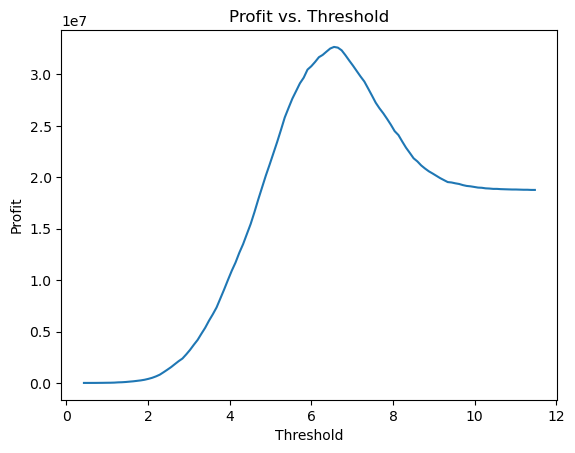

In [265]:

plt.plot(profit_frame['threshold'], profit_frame['profit'])

plt.xlabel('Threshold')
plt.ylabel('Profit')
plt.title('Profit vs. Threshold')

From this diagram, we can see that the profit peaks when we set the threshold to be around 6. In fact, my code has determined that the when we set the threshold to be 6.55, the best profit can be reached. At $t = 6.55$, the profit per borrower is

In [266]:
best_profit/len(X_train)

1387.0591712036908

### Evaluate Your Model from the Bank's Perspective

In [267]:
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/test.csv"
df_test = pd.read_csv(url)
df_test.dropna(inplace=True)
df_test

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,21,42000,RENT,5.0,VENTURE,D,1000,15.58,1,0.02,N,4
1,32,51000,MORTGAGE,2.0,DEBTCONSOLIDATION,B,15000,11.36,0,0.29,N,9
2,35,54084,RENT,2.0,DEBTCONSOLIDATION,C,3000,12.61,0,0.06,N,6
3,28,66300,MORTGAGE,11.0,MEDICAL,D,12000,14.11,1,0.15,N,6
4,22,70550,RENT,0.0,MEDICAL,E,7000,15.88,1,0.08,N,3
...,...,...,...,...,...,...,...,...,...,...,...,...
6511,29,78000,MORTGAGE,2.0,PERSONAL,A,18000,6.62,0,0.23,N,5
6513,27,44640,RENT,0.0,MEDICAL,B,12800,11.83,0,0.29,N,9
6514,24,48000,OWN,5.0,VENTURE,A,10400,7.37,0,0.22,N,3
6515,26,65000,MORTGAGE,6.0,EDUCATION,A,6000,9.07,0,0.09,N,3


In [268]:
df_test_forModel = pd.get_dummies(df_test)
df_test_forModel = df_test_forModel[selected_columns]

t=6.55

df_test['new_score'] = score_function(LR.coef_, selected_columns, df_test_forModel)
df_test['predicted_loan_status'] = df_test['new_score'] >= t


In [269]:
TrueNegative = df_test[(df_test['predicted_loan_status'] == False) & (df_test['loan_status'] == 0)]
TrueNegative_list = TrueNegative["loan_amnt"] * (1 + 0.25 * TrueNegative["loan_int_rate"]/100)**10 - TrueNegative["loan_amnt"]
TrueNegative_gain = TrueNegative_list.sum()

FalseNegative = df_test[(df_test['predicted_loan_status'] == False) & (df_test['loan_status'] == 1)]
FalseNegative_list = FalseNegative["loan_amnt"] * (1 + 0.25 * FalseNegative["loan_int_rate"]/100)**3 - 1.7 * FalseNegative["loan_amnt"]
FalseNegative_cost = FalseNegative_list.sum()

(FalseNegative_cost+TrueNegative_gain)/len(df_test)

1325.9668532238354

### Evaluate Your Model From the Borrower’s Perspective

Is it more difficulty for people in certain age groups to access credit under my proposed system? Let's see the result. 

In [271]:
df_test['Age_Range'] = df_test['person_age'].apply(assign_age_range)
df_test.groupby(["Age_Range","predicted_loan_status"]).size().reset_index(name='count')

,Age_Range,predicted_loan_status,count
0,20-30,False,3468
1,20-30,True,673
2,30-40,False,1107
3,30-40,True,167
4,40-50,False,233
5,40-50,True,27
6,50-60,False,38
7,50-60,True,4
8,60-70,False,6
9,60-70,True,6


In [284]:
df_test.groupby("Age_Range")["predicted_loan_status"].agg(lambda x: (x == True).mean() * 100).reset_index() # adopted from ChatGPT

,Age_Range,predicted_loan_status
0,20-30,16.252113
1,30-40,13.108320
2,40-50,10.384615
3,50-60,9.523810
4,60-70,50.000000
5,70-80,0.000000


Although 50 percent of people are predicted to be defaulted for the age 50 to 60 group, the number of sample in this group is very small (only 4 person). Other than the 50 to 60 range, it is more difficult for people with age between 20 to 30 to access their credit. As the age range increases, the probability that my model would grant credit to each individual increases. Now, we want to see how different loan intents may affect how my model would be more likely or less likely to give them grants. 

In [274]:
df_test.groupby(["loan_intent","predicted_loan_status"]).size().reset_index(name='count')

,loan_intent,predicted_loan_status,count
0,DEBTCONSOLIDATION,False,756
1,DEBTCONSOLIDATION,True,148
2,EDUCATION,False,1008
3,EDUCATION,True,168
4,HOMEIMPROVEMENT,False,535
5,HOMEIMPROVEMENT,True,81
6,MEDICAL,False,897
7,MEDICAL,True,176
8,PERSONAL,False,834
9,PERSONAL,True,164


In [281]:
df_test.groupby("loan_intent")["predicted_loan_status"].agg(lambda x: (x == True).mean() * 100).reset_index()

,loan_intent,predicted_loan_status
0,DEBTCONSOLIDATION,16.371681
1,EDUCATION,14.285714
2,HOMEIMPROVEMENT,13.149351
3,MEDICAL,16.402610
4,PERSONAL,16.432866
5,VENTURE,14.522822


According to the prediction of my model, the probability for a loan to be defaulted across different loaning intent is similar. Home imporvement loans see a slightly lower probability of defaulting. Next, we want to see what is is the count of default for loans with different intents in reality. 

In [280]:
df_test.groupby(["loan_intent","loan_status"]).size().reset_index(name='count')

,loan_intent,loan_status,count
0,DEBTCONSOLIDATION,0,644
1,DEBTCONSOLIDATION,1,260
2,EDUCATION,0,979
3,EDUCATION,1,197
4,HOMEIMPROVEMENT,0,462
5,HOMEIMPROVEMENT,1,154
6,MEDICAL,0,768
7,MEDICAL,1,305
8,PERSONAL,0,778
9,PERSONAL,1,220


In [283]:
df_test.groupby("loan_intent")["loan_status"].agg(lambda x: (x == 1).mean() * 100).reset_index()

,loan_intent,loan_status
0,DEBTCONSOLIDATION,28.761062
1,EDUCATION,16.751701
2,HOMEIMPROVEMENT,25.000000
3,MEDICAL,28.424977
4,PERSONAL,22.044088
5,VENTURE,14.626556


Loans borrowed for debt consolidation and medical purposes in reality have higher probability of defaulting. On the other hand, loans borrowed fro education and venture purposes have lower probability of defaulting. Next, I will use a graph to show whether the income level and the interest rate impact the ease with which an individual can access credit under my decision system. 

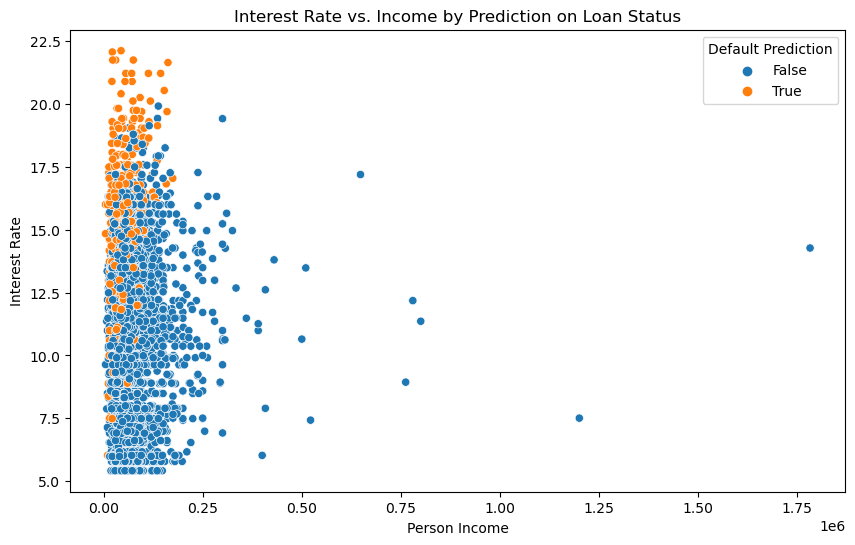

In [286]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_test, x='person_income', y='loan_int_rate', hue= 'predicted_loan_status')
plt.title("Interest Rate vs. Income by Prediction on Loan Status")
plt.xlabel('Person Income')
plt.ylabel('Interest Rate')
plt.legend(title='Default Prediction')
plt.show()



Here, we can see that most of the individuals that my model predict will default has lower income. Specifically, individuals who have low income and high interest rate have large probability of defaulting according to my model's prediction. People with higher income do have more ease when my model is deciding whether to grant them a loan: my model is not predicting any individual will default a loan when its income is higher than 200k. 

### Conclusion

Refering back to my previous blog post, I was using different types of machine learning models to classify penguin species using their physiological features, and one of the models I used is logistic regression model. In this post, instead of letting the model to classify for us automatically, we utilized the weight coefficient vectors, calculate the scores, and assigned a threshold using a relatively simplified profit calculating model to maximize bank's profit. I learned that the decision-making of a machine learning model is not always motivated by higher accuracy; instead, we can intervene the model and make the model to generate prediction result that would meet our specific needs, such as profit in this case. 

This also leads to a discussion about the fairness of decision making. Among all these loans, there are some loans that have medical intentions. These loans may be crucial in saving ones life. The decision that the bank make is directly linked to whether this person would have a change to live or sentence to death. In this case, if our model is driven by soely profit, then from the table above there are 16.4% of people who asked for medical loan won't get the money. In our group discussion during the class, we stated that a fairness decision is made after both rational and emotional evaluation. In this loan-granting case, I believe that there should be more emotional component involved in the loan granting, especially when it it about saving one's life. 